## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference/run/user/1000/doc/28cc874b/model_4_unet_train.ipynb

In [1]:
# hash comments indicate Joe, TK comments are specified


#To create all of these utilize the requirements.txt that I sent in conda, if you decide to run locally will need to change to cpu


from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

/home/joe/anaconda3/envs/vesuvius/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3090'

In [51]:
#Install github repos used for this project

In [52]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [53]:
!pip install segmentation_models_pytorch

In [54]:
import segmentation_models_pytorch as smp

In [55]:
!pip install warmup_scheduler

In [56]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [57]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

#This is the main place that I edited the models, I experimented with in_chans, stride, and file size


class CFG:
    # ============== comp exp name ============= (TK)
    comp_name = 'vesuvius'

    # comp_dir_path = './'  (TK)
    comp_dir_path = '/kaggle/input/'

    #Set this directory to whever you are working out of, if on kaggle can remove commented code and run that way
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_folder_name}/'


    #Results are saved to the below file in output directory
    exp_name = 'vesuvius_2d_slide_exp002'

    # ============== pred target ============= (TK)
    target_size = 1

    # ============== model cfg ============= (TK)
    #I customized these model names to in a standard format to make it easy to tell which run it was
    model_name = 'unet_fold_2_enet_resnet'
    #backbone = 'efficientnet-b0'  (TK)

    #I tried to run on se_resnext5_32x4d but I was prompted to download model weights from a source that does not use SSL to
    #transmit the data. I do not want to do this because my OS warned me it could be me at risk for a virus and I am not sure about
    #the source as it is not academic or from the official pytorch team. The only challenge is that this network type is used in 
    #inference and my model weights are not working when I run the notebook in Kaggle.

    #backbone = 'se_resnext50_32x4d' 


    #I experimented with resnet50 and efficientnet-b0. I also ran one with efficientnet-b7 but it got similar results and I did not
    #see a compelling reason to continue down that path.
    backbone = 'efficientnet-b0'


    #Still stumped by this one. Using 6 is very fast but I am not convinced that it would really work.
    in_chans = 32 # 65
    # ============== training cfg ============= (TK)
    
    size = 224
    tile_size = 224
    stride = tile_size // 4

    #Have to change this based on the number of in channels and the size of the images 
    train_batch_size =  8# 32
    valid_batch_size = train_batch_size 

    
    use_amp = True

    #scheduler = 'GradualWarmupSchedulerV2'
    
    #Trying the different scheduler per code review
    scheduler = 'CosineAnnealingLR' 
    epochs = 10 # 30

    # adamW warmupあり (TK) 
    warmup_factor = 10

    lr = 1e-5 / warmup_factor

    # ============== fold ============= (TK)
    valid_id = 2

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression' (TK)
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed ============= (TK)
    pretrained = True
    inf_weight = 'best'  # 'best'
#changed to 1e-4 to 1e-6 (TK)
    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50

    #Will want to change this based on your cpu
    num_workers = 24

    #Try changing seed per code review
    seed = 99

    # ============== set dataset path ============= (TK)
    print('set dataset path')

    outputs_path = f'output/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'
    model_dir = outputs_path + \
        f'{comp_name}-models/'
    
    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'


    #I tried removing some of the transformations and adding them back in, saw significant decrease in performance when I removed all but
    #the ones on the validation transformation

    # ============== augmentation ============= (TK)
    train_aug_list = [
       # A.RandomResizedCrop(
       #      size, size, scale=(0.08, .2)), (TK)
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
     #   A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0), (TK)
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]
    
    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [58]:
#just used to keep track of the losses
class AverageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [59]:
#Logger, I have some issues with it (in prints 3 of the same line into the output.txt)
#I think I can just load in the file and cast set to remove the duplicates and then extract the data
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    #May need to comment out this cuda code if you run

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [60]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [61]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [62]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S')) (TK)



-------- exp_info -----------------


-------- exp_info -----------------


## image, mask

In [63]:
#I did not understand if cv2 could open tiff files while conserving all information, so I decided to try to load the tiff files in with this library
import tifffile as tiff
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2

    #idxs = range(start, end)

    #I played around with idxs a little bit, each of the time I would change it
    #the network would barely train or do worse, I tried the configuration below 
    #I also tried the top 7 and bottom 7 exclusively. 

    #Per code request trying this again, one more try with this then I will attempt 3d conv
    idxs = [0, 5, 10, 15, 20, 25,26,27,28,29,30,31,32,33,34,35,36,37
            ,38,39,40,45,50,55,60,64]
    print(idxs)
    
    for i in tqdm(idxs):
        empty = True
        res = None
            
        #image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)
        image = tiff.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif")

        #Image padding to make sure all CNN layers can run here
        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)
        
        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)
        
        #res = res/4
        images.append(image)
    images = np.stack(images, axis=2)
    print("after images")
    print(images.shape)
    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
   # mask = tiff.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png")
    print("reading mask")
    print(mask.shape)
    print(fragment_id)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [64]:
#Splits the  dataset based off of the valid_id
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

   
    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2)) (TK)
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [65]:
#This is usually the first place something goes wrong when I have an out of memory error
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

range(29, 35)


100%|██████████| 6/6 [00:00<00:00, 13.47it/s]


after images
(8288, 6496, 6)
reading mask
(8181, 6330)
1
range(29, 35)


100%|██████████| 6/6 [00:02<00:00,  2.14it/s]


after images
(15008, 9632, 6)
reading mask
(14830, 9506)
2
range(29, 35)


100%|██████████| 6/6 [00:01<00:00,  4.10it/s]


after images
(7616, 5376, 6)
reading mask
(7606, 5249)
3


In [66]:
valid_xyxys = np.stack(valid_xyxys)

## dataset

In [67]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [68]:
#Simple class construction + function 
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df) (TK)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [69]:
#This was just a sanity check by me as I was unsure about the input
for image in train_masks:
    print(image.shape)

(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 

In [70]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [72]:
#I removed plotting code, I don't think we need it. @codereview

1786

## model

In [73]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1) (TK)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

## scheduler

In [74]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler



#This scheduler seems to work quite well, seeing how well it worked on a similar problem (medical) I think this is good
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [75]:
import requests

model = build_model(CFG)
model.to(device)
import requests


optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name unet_fold_2_enet_resnet
backbone resnet50


## loss

In [76]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

#Here the author acutally just uses BCELoss. I read a stackexchange post that DICE leads to exploding gradient
def criterion(y_pred, y_true):
    #I agree @review, may need to run with some BCE for numerical stability, but dice loss needed for greatest performance (I would imagine)
    return 0.2 * BCELoss(y_pred, y_true) + 0.8 * DiceLoss(y_pred, y_true) 
    #return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true) (TK)

## train, val

In [77]:
#Seem like somewhat standard train, valid helper functions for instance segmentation model triaining in pytorch
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        
        # Create mask for prediction
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [78]:
from sklearn.metrics import fbeta_score

#This function comes from another user who implemented dice coefficient themself
def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

#This calculates the optimal threshold for a given set of pixel predictions. I think that this might lead to 
#Some overtraining since it is a parameter that is based just on the validation set (of which we can only easily do 3 fold)

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    #for th in np.array(range(10, 50+1, 5)) / 100:
    #Joe Comment: I chanaged this threshold after seeing some posts (not code)
    #on the kaggle forums about using threshold over .5 with positive results
    for th in np.array(range(10, 70+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5) 
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [79]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [80]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

#The actual training code, I really like how it looks with the helper functions
for epoch in range(CFG.epochs):

    start_time = time.time()

    # train (TK)
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval (TK) 
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    #Step with the custom scheduler
    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss (TK)
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}') (TK)
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

       
        #Saves the best score
        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth') 

"\nfold = CFG.valid_id\n\nif CFG.metric_direction == 'minimize':\n    best_score = np.inf\nelif CFG.metric_direction == 'maximize':\n    best_score = -1\n\nbest_loss = np.inf\n\nfor epoch in range(CFG.epochs):\n\n    start_time = time.time()\n\n    # train\n    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)\n\n    # eval\n    avg_val_loss, mask_pred = valid_fn(\n        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)\n\n    scheduler_step(scheduler, avg_val_loss, epoch)\n\n    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)\n\n    # score = avg_val_loss\n    score = best_dice\n\n    elapsed = time.time() - start_time\n\n    Logger.info(\n        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')\n    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')\n    Logger.info(\n        f'Epoch {epoch+1} - avgScore: {score:.4f}')\n\n    if CFG.metric_direction == 'minimize':\n 

In [81]:
check_point = torch.load(
    'output/vesuvius-models/unet_enet_chans_6_thresh_7_size_224_stide_4_batch_16_fold1_best.pth', map_location=torch.device('cpu'))

In [82]:
mask_pred = check_point['preds']

In [83]:

best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)
#@review, I don't think this is overtraining actually. To be on the safe size we can split up each scroll into smaller fragments to 
#get a better cross validation score. Something like 10-fold (I think it could be done)

th: 0.1, fbeta: 0.4480779756642488
th: 0.15, fbeta: 0.4855867813851171
th: 0.2, fbeta: 0.5119855202315065
th: 0.25, fbeta: 0.5314114878510144
th: 0.3, fbeta: 0.5435170607985508
th: 0.35, fbeta: 0.547746370390241
th: 0.4, fbeta: 0.5461181303713111
th: 0.45, fbeta: 0.5381942804815473


best_th: 0.35, fbeta: 0.547746370390241
best_th: 0.35, fbeta: 0.547746370390241


th: 0.5, fbeta: 0.5265688640967607


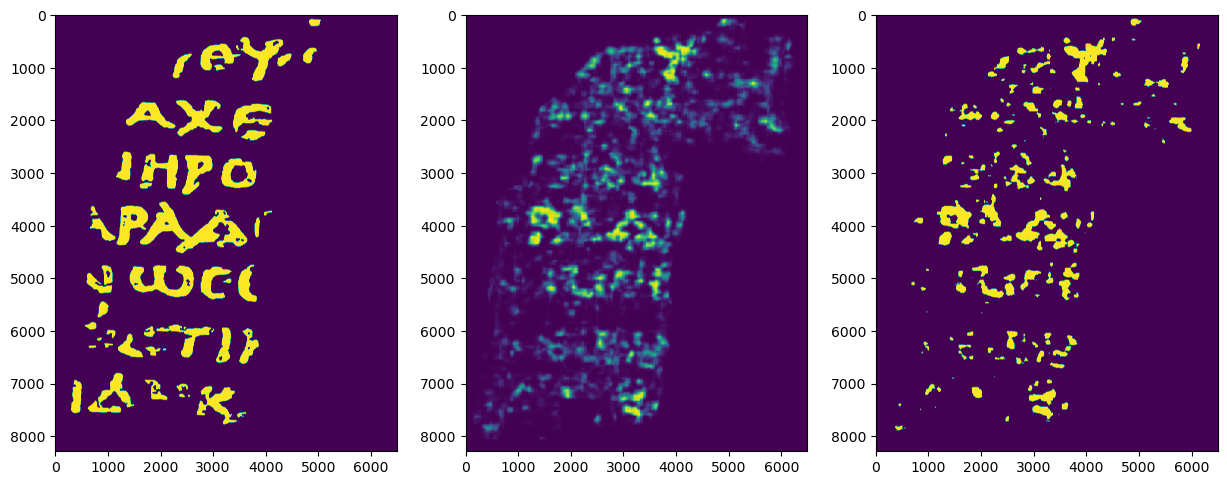

In [86]:

fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=.35).astype(int))

(array([42094177.,  3373616.,  1914284.,  1274705.,   959418.,   720443.,
          570142.,   477321.,   382318.,   309500.,   263861.,   237970.,
          209691.,   179192.,   159036.,   154143.,   145416.,   161187.,
          150786.,   101642.]),
 array([1.28878240e-07, 4.96611156e-02, 9.93221024e-02, 1.48983089e-01,
        1.98644076e-01, 2.48305063e-01, 2.97966049e-01, 3.47627036e-01,
        3.97288023e-01, 4.46949010e-01, 4.96609996e-01, 5.46270983e-01,
        5.95931970e-01, 6.45592956e-01, 6.95253943e-01, 7.44914930e-01,
        7.94575917e-01, 8.44236903e-01, 8.93897890e-01, 9.43558877e-01,
        9.93219864e-01]),
 <BarContainer object of 20 artists>)

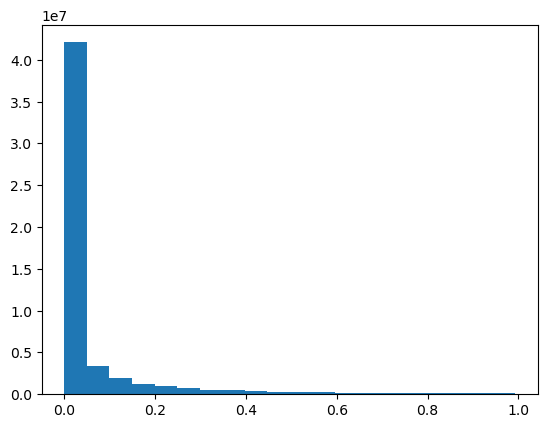

In [85]:
plt.hist(mask_pred.flatten(), bins=20)